In [12]:
%load_ext autoreload
%autoreload 2
import load_DLC
import load_prism
import torch
import yaml
import matplotlib.pyplot as plt
from liftpose.vision_3d import *
from liftpose.preprocess import concat_dict, total_frames, center_poses, anchor_to_root, flatten_dict, unflatten_dict
from liftpose.plot import plot_pose_3d, plot_pose_2d
from tqdm import tqdm
tqdm.get_lock().locks = []

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data in the source domain (fly-prism)

In [14]:
# declare data parameters
par_source = {'data_dir'       : '/data/LiftPose3D/fly_prism/data_oriented/',#mac/ubuntu path
             #'data_dir'       : r"\Users\NeLy\Desktop\fly_prism/data_oriented/training_data", #windows path  
             'out_dir'        : '/data/LiftPose3D/domain_adapt_LiftPose3D_station/',
             "train_subjects" : ["001","002","003","004"],
             'actions'        : ['PR']}

# merge with training parameters
par_data = yaml.full_load(open('param_LiftPose3D_station.yaml', "rb"))
par = {**par_data["data"], **par_source}

# load data
pts3d_source, _, _ = load_prism.load_3D(par["data_dir"], subjects=par['train_subjects'], actions=par['actions'])

#center
pts3d_source = center_poses(pts3d_source, par_data['data']['roots'])

#project data to ventral view
pts2d_source = XY_coord_dict(pts3d_source)

pts2d_source = concat_dict(pts2d_source)


# Load data in the target domain

In [25]:
# declare data parameters
par_target = {'data_dir'       : "/data/LiftPose3D/LiftPose3D_station/videos/", # change the path
             'out_dir'        : '/data/LiftPose3D/domain_adapt_LiftPose3D_station',
             "train_subjects" : ['Flyprism1','Flyprism2'],
             'experiments'    : ['liftPose_station8_80fps_flyCrop'],
             'scorer': 'DLC_resnet_50_LiftPose3DMar19shuffle1_300000'}

# merge with training parameters
par_data = yaml.full_load(open('param_LiftPose3D_station.yaml', "rb"))
par_target = {**par_data["data"], **par_target}

# load data
pts2d_target, keypts_target = load_DLC.load_2D(par_target["data_dir"], par_target['experiments'], par_target['scorer'])

#center (comment this when making video below)
pts2d_target = center_poses(pts2d_target,par_data['data']['roots'])

#concatenate dicts of experiments
pts2d_target = concat_dict(pts2d_target)
keypts_target = concat_dict(keypts_target)

#roots are bit wobbly across frames so stabilize them by anchoring and then adding the root for frame #1
pts2d_target = flatten_dict(pts2d_target)
#pts3d_target, offset = anchor_to_root(pts3d_target, par['roots'], par['target_sets'], 3)
#k0 = None
#for k in pts3d_target.keys():
#    if k0 is None:
#        k0=k
#    pts3d_target[k] += offset[k0][0,:]
    
pts2d_target = unflatten_dict(pts2d_target,2)

pts2d_target = pts2d_target['']

data_range = range(2120,2200)
pts2d_target = pts2d_target[data_range]

# Make video of DeepLabCut prediction in the desired data interval

[animation.py:329]:DEBUG:frame size in pixels is 2000 x 1000
[animation.py:345]:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 2000x1000 -pix_fmt rgba -r 10 -i pipe: -vcodec h264 -pix_fmt yuv420p -y DLC_pred.mp4
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab

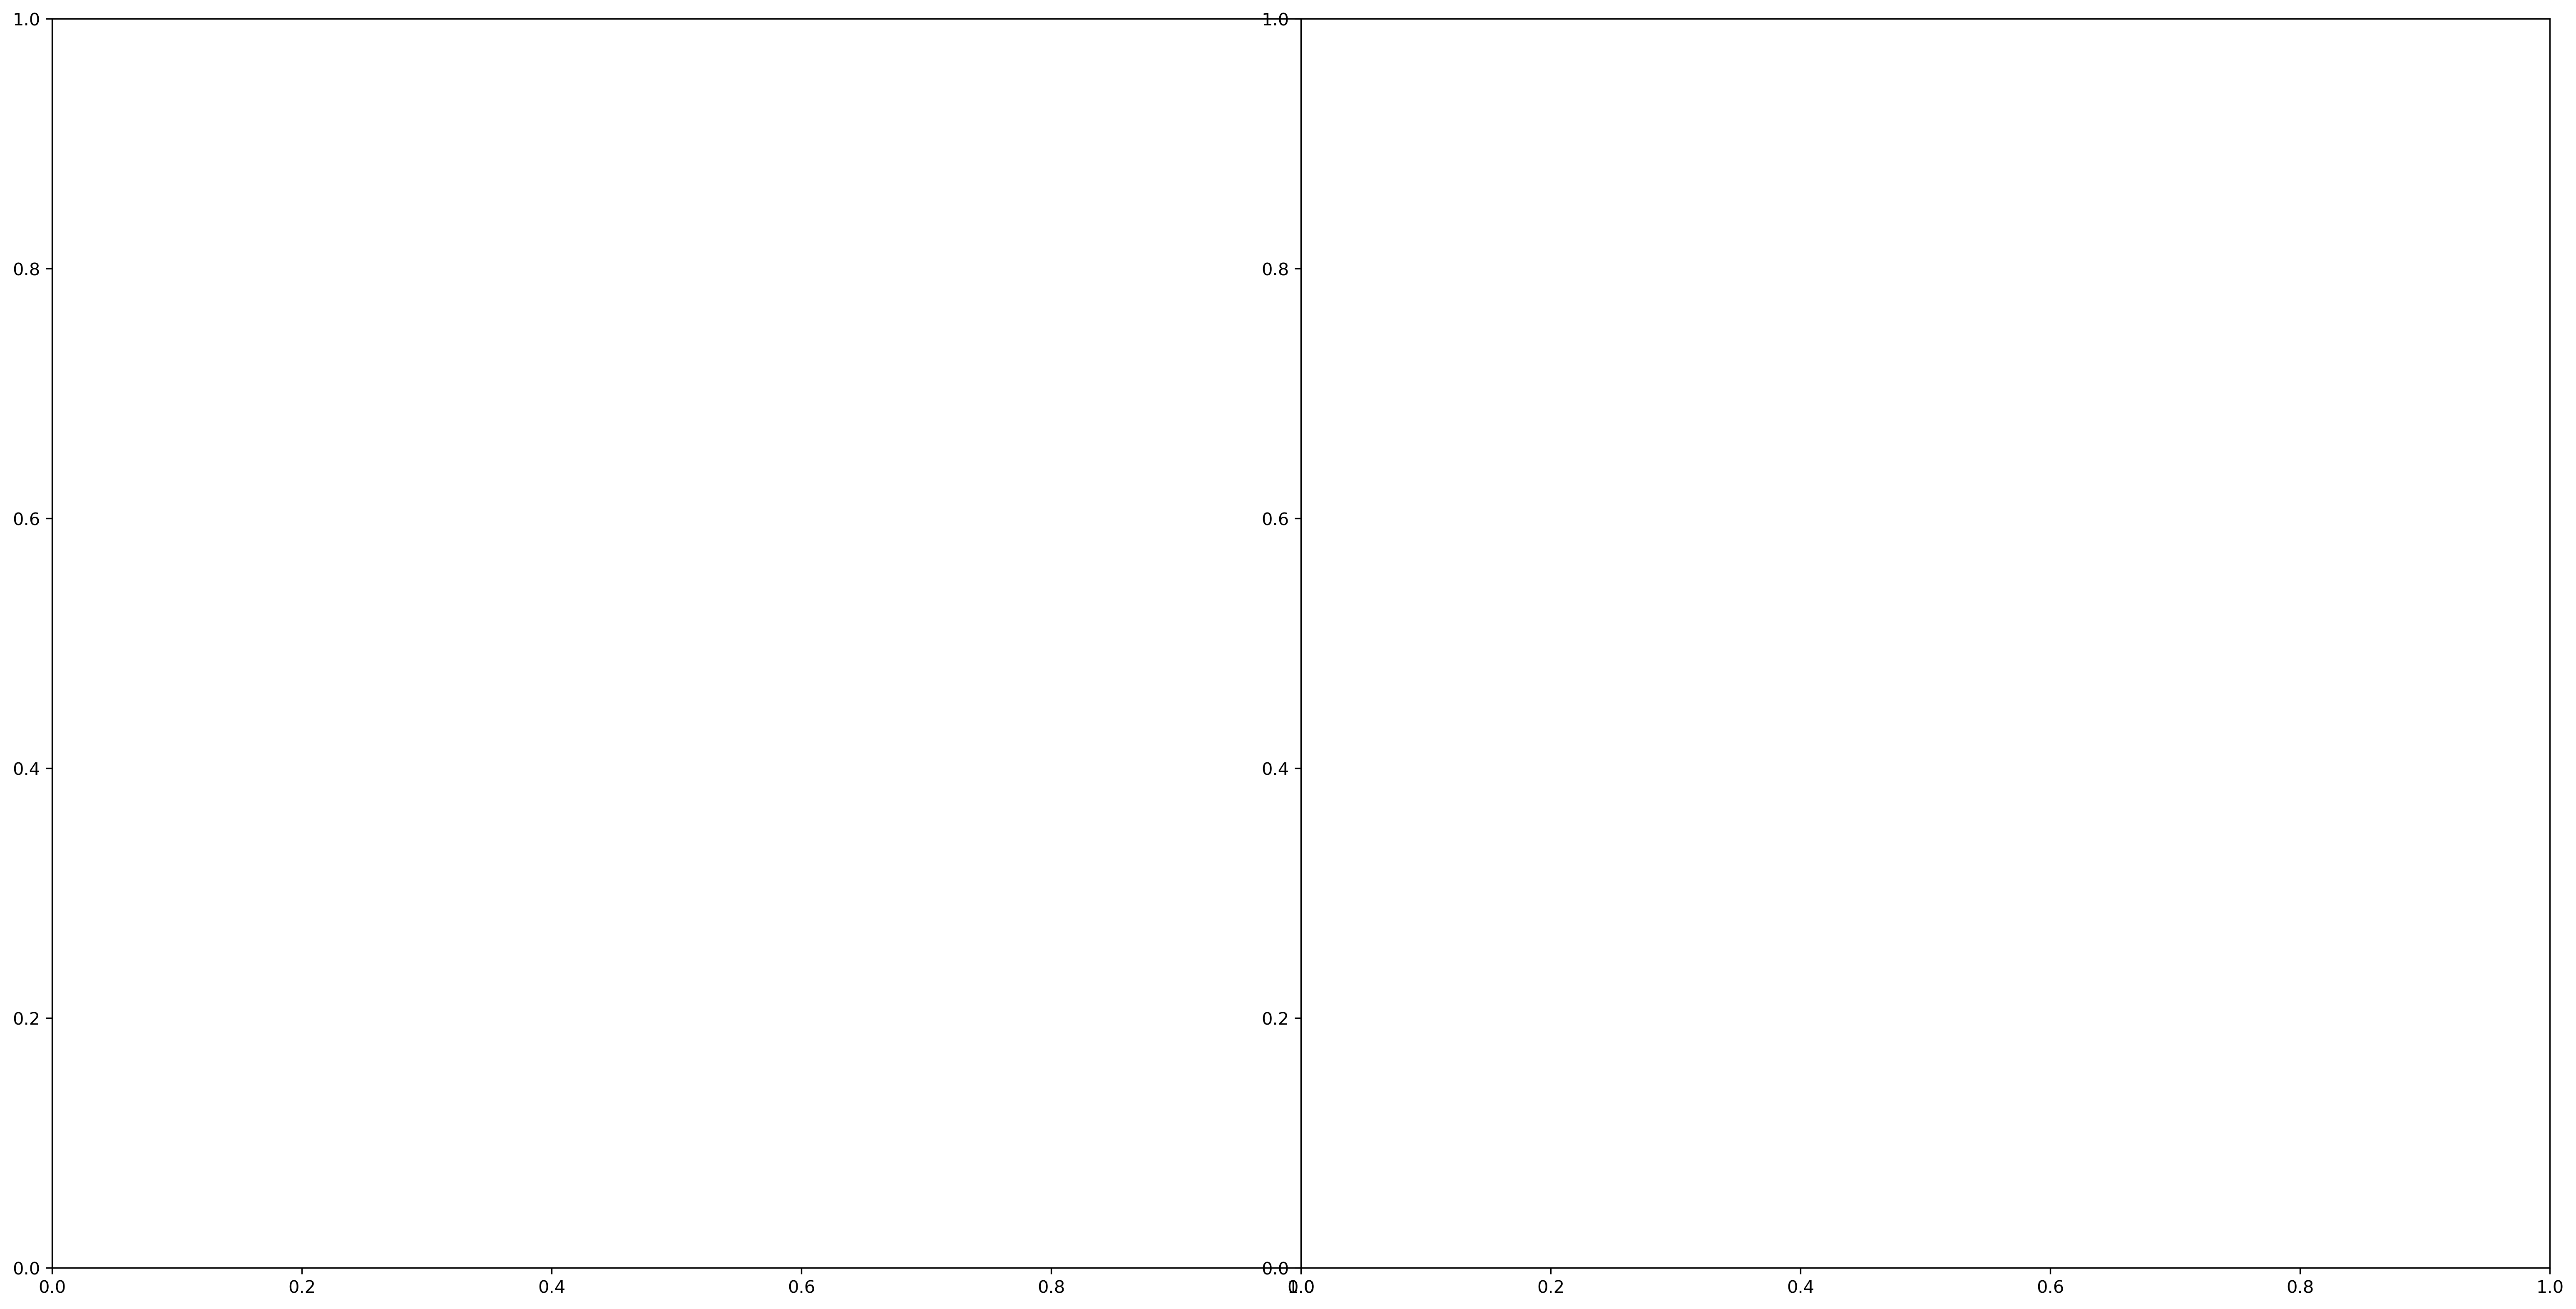

In [26]:
#comment out the centering above before making the videos
import cv2
import matplotlib.animation

def video_to_imgs(vid_path):
    '''Convert video to a list of images'''
    
    cap = cv2.VideoCapture(vid_path)         
    imgs = []            
    while True:
        flag, frame = cap.read()
        if flag:                            
            imgs.append(frame)       
        else:
            break        
    
    return imgs

fig = plt.figure(figsize=(20,10), dpi=300)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0.1, wspace = 0)

imgs = video_to_imgs(par_target['data_dir'] + 'liftPose_station8_80fps.mp4')
imgs_crop = video_to_imgs(par_target['data_dir'] + par_target['experiments'][0] + '.mp4')

writer = matplotlib.animation.FFMpegWriter(fps=10)
with writer.saving(fig, 'DLC_pred.mp4', dpi=100):
    for i, frame in enumerate(data_range):
        
        
        ax1.imshow(cv2.cvtColor(imgs[frame], cv2.COLOR_BGR2RGB))
        ax2.imshow(cv2.cvtColor(imgs_crop[frame], cv2.COLOR_BGR2RGB))
        
        plot_pose_2d(
            ax2,
            pts2d_target[i],
            normalize=False,
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"],  
            colors=par_data["vis"]["colors"],
            good_keypts=keypts_target
        )
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        
        writer.grab_frame()
        ax1.clear()
        ax2.clear()


# Find nearest neighbours

In [17]:
from tqdm.contrib.concurrent import process_map
from functools import partial
import pickle

nn = 10

try:
    poses, nns_2d = pickle.load(open(par_target['out_dir']+'/neighbors.pkl','rb'))

except:   
    total = pts2d_target.shape[0]
    poses = [i for i in range(pts2d_target.shape[0])]
                         
    #2D poses
    nns_2d = process_map(partial(find_neighbours, 
                         pts=pts2d_source,
                         target_pts=pts2d_target, 
                         nn=nn,
                         metric=1), 
                  poses, max_workers=16)

    pickle.dump([poses, nns_2d],open(par_target['out_dir']+'/neighbors.pkl','wb'))
    


# Find best linear transformation for 2D, d2

In [18]:
nn=1

A_est_2D = best_linear_map(pts2d_source, pts2d_target[poses], nns_2d, nn=nn)
pts2d_prism = apply_linear_map(A_est_2D, pts2d_target)


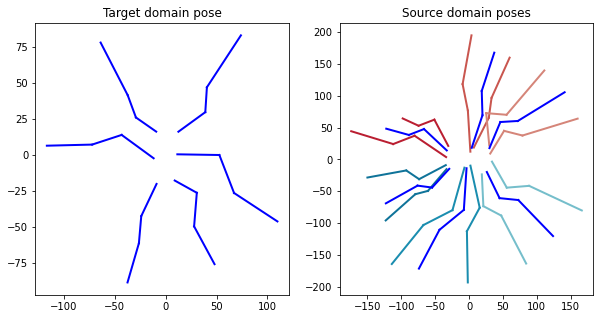

In [20]:
ind = 79

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
plot_pose_2d(
    ax, 
    pts2d_target[poses[ind]], 
    bones=par_data["vis"]["bones"], 
    limb_id=par_data["vis"]["limb_id"],  
    #colors=par_data["vis"]["colors"], 
)
ax.set_title('Target domain pose')

ax = fig.add_subplot(122)
ax.set_title('Source domain poses')

for i in nns_2d[ind][:2]:
    plot_pose_2d(
        ax, 
        pts2d_source[i], 
        bones=par_data["vis"]["bones"], 
        limb_id=par_data["vis"]["limb_id"],  
        colors=par_data["vis"]["colors"], 
    )
    
plot_pose_2d(
    ax, 
    pts2d_prism[poses[ind]], 
    bones=par_data["vis"]["bones"], 
    limb_id=par_data["vis"]["limb_id"],  
    #colors=par_data["vis"]["colors"], 
)
#plt.savefig('2D_mapping.svg')

# Predict poses with trained network

In [21]:
from liftpose.postprocess import load_test_results
from liftpose.main import set_test_data
from liftpose.main import test as lp3d_test
from liftpose.lifter.utils import filter_data

kp = keypts_target
        
#normalize test data
test_2d, test_3d, stat_2d, stat_3d = set_test_data(par_target['out_dir'], {'test_2d':pts2d_prism.copy()})
    
#test data on network
lp3d_test(par_target['out_dir'], test_2d, test_3d)
    
#load statistics and test results
_, pred, _ = load_test_results(par_target['out_dir'], stat_2d, stat_3d, prism=True)

#filter noise
pred = filter_data(pred,window=7, order=2)


[main.py:335]:INFO:starting testing in path: /data/LiftPose3D/domain_adapt_LiftPose3D_station
[lift.py:44]:INFO:Training on the device: cuda:0
[lift.py:71]:INFO:total params: 4.26M
[lift.py:79]:INFO:loading ckpt from '/data/LiftPose3D/domain_adapt_LiftPose3D_station/ckpt_best.pth.tar'
[lift.py:87]:INFO:ckpt loaded (epoch: 27 | err: 1.0419670028104635)
[lift.py:118]:INFO:Saving results: /data/LiftPose3D/domain_adapt_LiftPose3D_station/test_results.pth.tar


[pyplot.py:289]:DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


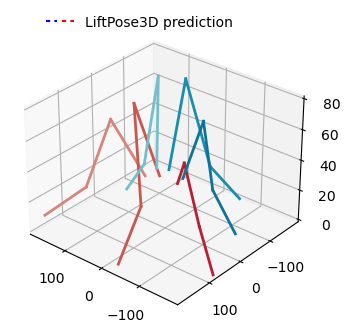

In [22]:
%matplotlib inline
from liftpose.plot import plot_pose_3d

t = 0

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=130)

ax.set_xlim([-190,190])
ax.set_ylim([-190,190])
ax.set_zlim([0,80])

plot_pose_3d(ax=ax, bones=par_data["vis"]["bones"],
             pred=pred[t], 
             normalize=False, 
             limb_id=par_data["vis"]["limb_id"], 
             colors=par_data["vis"]["colors"],
             axes=True,
             legend=True)


# Video

[animation.py:329]:DEBUG:frame size in pixels is 1200 x 1200
[animation.py:345]:INFO:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x1200 -pix_fmt rgba -r 10 -i pipe: -vcodec h264 -pix_fmt yuv420p -y LP3D_prediction.mp4
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWriter.grab_frame: Grabbing frame.
[animation.py:358]:DEBUG:MovieWrit

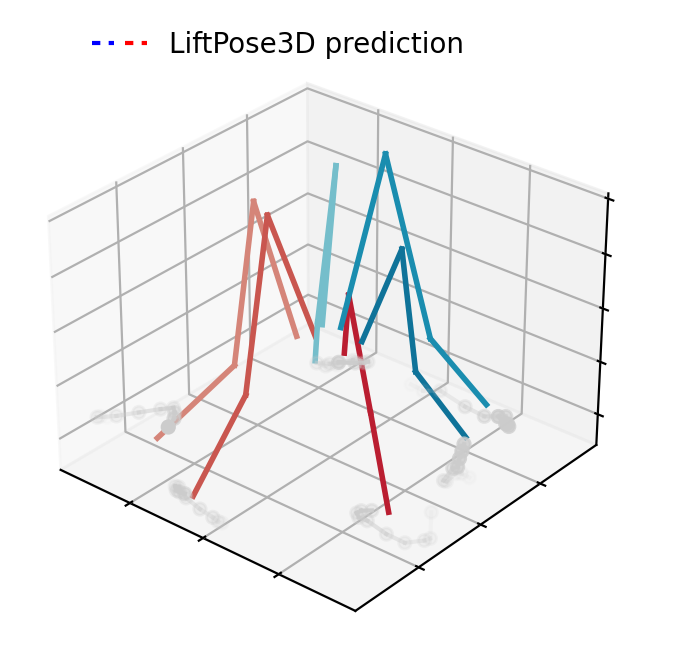

In [23]:
from liftpose.plot import plot_video_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=200)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=130)

ax.set_xlim([-190,190])
ax.set_ylim([-190,190])
ax.set_zlim([-10,80])

plot_video_3d(fig, ax, n=pred.shape[0], par=par_data, pred=pred, trailing=10, trailing_keypts=[3,7,11,15,19,23], fps=10)

In [27]:
!ffmpeg -i DLC_pred.mp4 -i LP3D_prediction.mp4 -filter_complex "[0:v]scale=-1:1200[v0];[v0][1:v]hstack=inputs=2" video_10.mp4 -y


ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib